In [1]:
import pandas as pd
import numpy as np
import sqlite3
import pyfolio as pf
import datetime


In [2]:
con = sqlite3.connect('./data/kor_stock.db')
sql = "SELECT * FROM kor_qv_portfolio"
raw_data = pd.read_sql(sql, con)
con.close()


In [3]:
qv_port = raw_data[raw_data['price'] >= 0.8]    # EBIT/EV 상위 20% 필터링
qv_port['rank'] = qv_port.groupby('year')['quality'].rank(method='min', ascending=False)    # 필터링된 종목들에 대해 연도별로 Quality 순위 매김
qv_port = qv_port[qv_port['rank'] <= 20].sort_values(['year', 'rank'])  # Quality 순위 상위 20위 필터링


In [4]:
def get_price(year, stock_cd=None):
    con = sqlite3.connect('./data/kor_stock.db')
    sql = "SELECT * FROM kor_price WHERE DATE(date) BETWEEN " + \
          "'" + str(year) + "-07-01' AND " +\
          "'" + str(year+1) + "-06-30'"
    if stock_cd == None:
        pass
    elif type(stock_cd) != list:
        raise TypeError('종목코드는 리스트 형태로 입력하여야합니다.')
    else:
        stock_cd_list = ','.join("'" + str(x) + "'" for x in stock_cd)
        sql = sql + " AND stock_cd IN (" + stock_cd_list + ")"
    df = pd.read_sql(sql, con)
    con.close()
    return df


In [5]:
port_ret_df = pd.DataFrame()
stock_ret_df = pd.DataFrame()

for year in range(2003, 2020):
    stock_cd_list = list(qv_port[qv_port['year'] == year]['stock_cd'])
    price_df = get_price(year, stock_cd_list)
    price_df = price_df.pivot_table(values='price', index='date', columns='stock_cd')
    ret_df = price_df.pct_change().fillna(0)
    ret_df = ret_df + 1
    ret_df = ret_df.cumprod().fillna(1)
    ret_df = ret_df - 1
    ret_df['port_cum_ret'] = ret_df.mean(axis=1)    # 동일비중 투자 가정
    ret_df['port_daily_ret'] = ret_df['port_cum_ret'].shift(1).fillna(0)
    ret_df['port_daily_ret'] = ((1 + ret_df['port_cum_ret']) / (1+ ret_df['port_daily_ret'])) - 1
    port_ret_df = pd.concat([port_ret_df, ret_df[['port_daily_ret', 'port_cum_ret']]])
    ret_df = pd.DataFrame(ret_df.iloc[-1, :-2])
    stock_ret_df = pd.concat([stock_ret_df, ret_df], axis=1)
    
port_ret_df = port_ret_df.reset_index()
port_ret_df['date'] = port_ret_df['date'].map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
port_ret_df.set_index(port_ret_df['date'], inplace=True)
port_ret_df = port_ret_df[['port_daily_ret', 'port_cum_ret']]


Start date,2003-07-01
End date,2020-06-11
Total months,199
,Backtest
Annual return,12.565%
Cumulative returns,616.268%
Annual volatility,20.193%
Sharpe ratio,0.69
Calmar ratio,0.21
Stability,0.81
Max drawdown,-61.035%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,61.04,2007-10-02,2008-10-27,2013-05-07,1461
1,47.71,2018-06-12,2020-03-19,NaT,NaN
2,19.97,2015-07-21,2015-08-24,2015-09-22,46
3,17.13,2013-05-09,2013-12-12,2014-04-04,237
4,17.12,2006-05-03,2006-07-18,2006-11-27,149


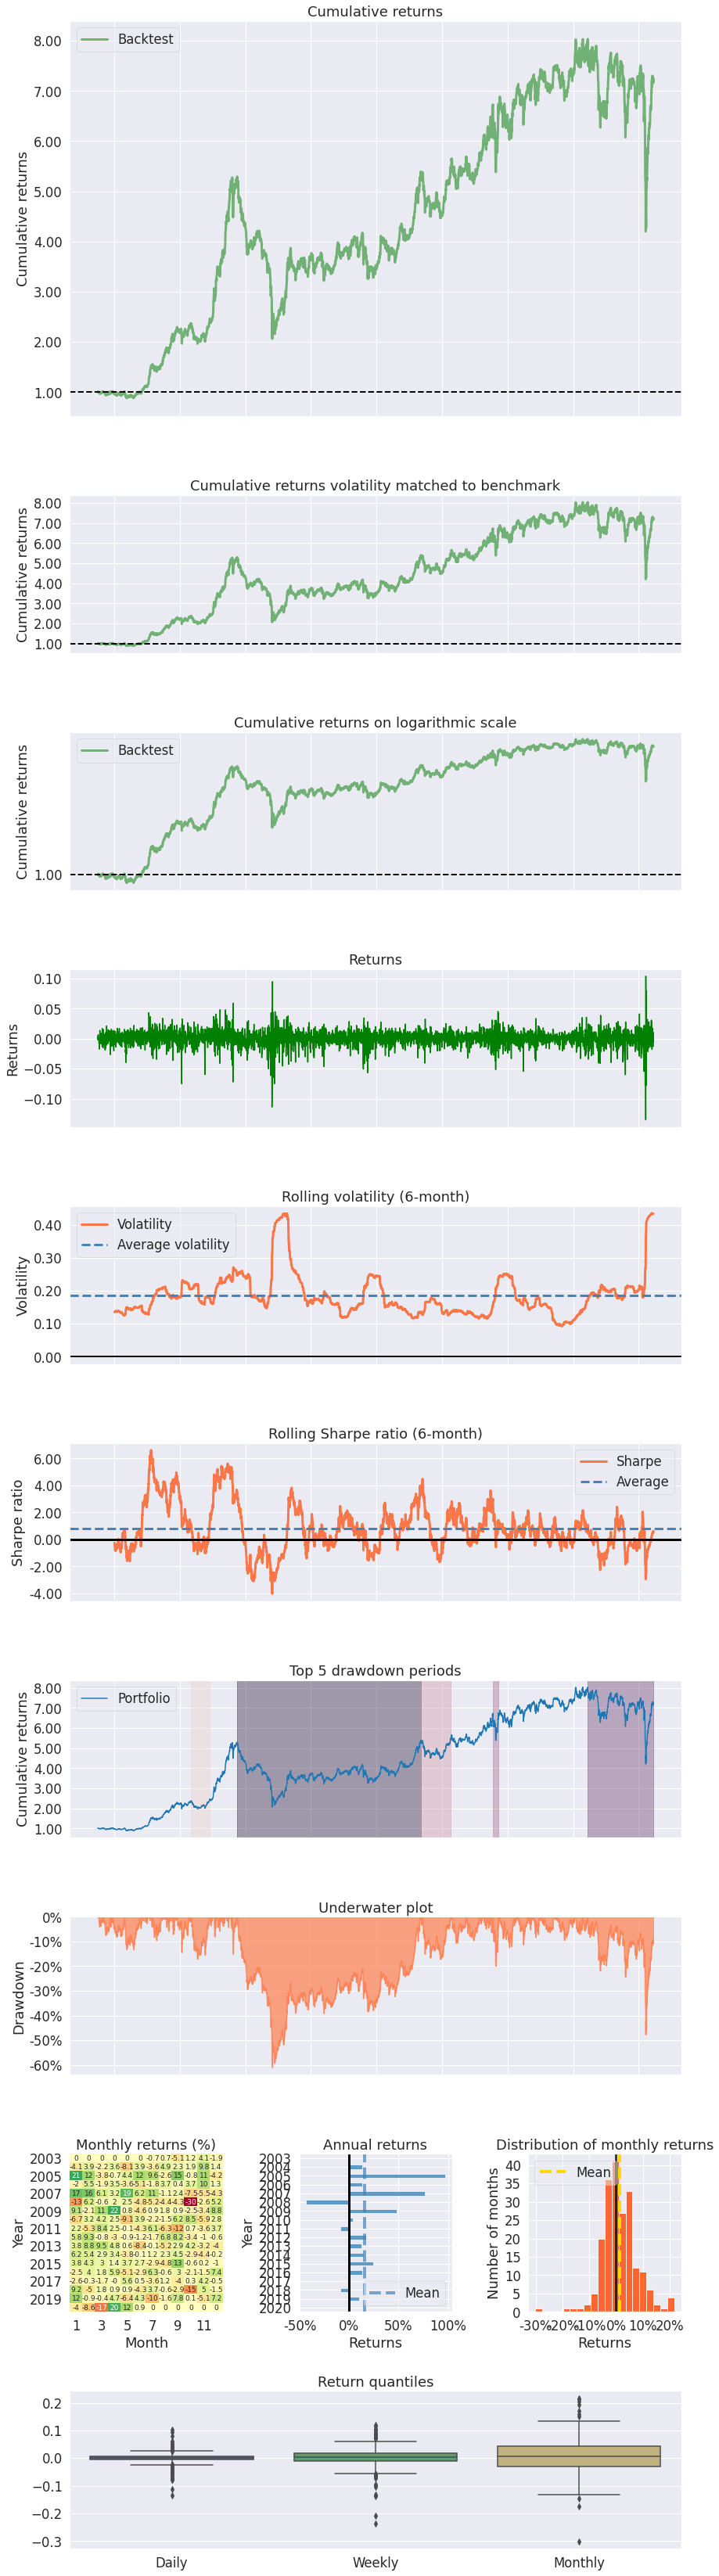

In [6]:
pf.create_returns_tear_sheet(port_ret_df['port_daily_ret'])


In [7]:
con = sqlite3.connect('./data/kor_stock.db')
sql = "select * from kor_ticker"
ticker = pd.read_sql(sql, con)
con.close()

stock_ret_df = pd.merge(stock_ret_df, 
                        ticker[['stock_cd', 'stock_nm', 'fn_sec_nm']], 
                        left_on=stock_ret_df.index, 
                        right_on='stock_cd', 
                        how='left')

half_year = stock_ret_df.columns[stock_ret_df.columns.str.startswith('2020')][0]
stock_ret_df.loc[~stock_ret_df[half_year].isna(), ['stock_cd', 'stock_nm', half_year]]


,stock_cd,stock_nm,2020-06-11
12,A016090,대현,-0.279208
145,A020000,한섬,-0.044017
203,A018310,삼목에스폼,-0.351020
205,A039010,현대통신,-0.320398
208,A042700,한미반도체,0.134228
238,A109080,옵티시스,0.093750
241,A028100,동아지질,-0.427273
254,A001820,삼화콘덴서,0.097701
255,A002170,삼양통상,-0.176647
256,A004000,롯데정밀화학,-0.293785


In [8]:
half_year = stock_ret_df.columns[stock_ret_df.columns.str.startswith('2019')][0]
stock_ret_df.loc[~stock_ret_df[half_year].isna(), ['stock_cd', 'stock_nm', half_year]]

,stock_cd,stock_nm,2019-06-28
46,A011170,롯데케미칼,-0.234848
81,A013120,동원개발,0.334197
163,A056190,에스에프에이,0.249226
170,A005710,대원산업,-0.081042
199,A108230,톱텍,-0.608017
232,A011370,서한,-0.166667
240,A000660,SK하이닉스,-0.169654
241,A028100,동아지질,0.512195
242,A035200,프럼파스트,-0.243407
243,A037440,희림,-0.053741


In [9]:
half_year = stock_ret_df.columns[stock_ret_df.columns.str.startswith('2018')][0]
stock_ret_df.loc[~stock_ret_df[half_year].isna(), ['stock_cd', 'stock_nm', half_year]]

,stock_cd,stock_nm,2018-06-29
12,A016090,대현,-0.152350
28,A007700,F&F,2.044776
30,A011040,경동제약,0.281647
50,A023150,MH에탄올,-0.308913
69,A033130,디지틀조선,-0.107456
102,A036190,금화피에스시,-0.030471
115,A028150,GS홈쇼핑,-0.223565
181,A064480,브리지텍,-0.492647
189,A036800,나이스정보통신,-0.058052
229,A161000,애경유화,-0.282540


In [10]:
half_year = stock_ret_df.columns[stock_ret_df.columns.str.startswith('2017')][0]
stock_ret_df.loc[~stock_ret_df[half_year].isna(), ['stock_cd', 'stock_nm', half_year]]

,stock_cd,stock_nm,2017-06-30
46,A011170,롯데케미칼,0.204904
50,A023150,MH에탄올,0.105263
77,A006650,대한유화,0.060797
103,A039340,한국경제TV,-0.270690
114,A023890,한국아트라스비엑스,0.007407
200,A120030,조선선재,0.300485
216,A004780,대륙제관,0.044118
217,A008370,원풍,-0.045407
218,A012630,HDC,0.202308
219,A023910,대한약품,0.156040


In [11]:
half_year = stock_ret_df.columns[stock_ret_df.columns.str.startswith('2016')][0]
stock_ret_df.loc[~stock_ret_df[half_year].isna(), ['stock_cd', 'stock_nm', half_year]]

,stock_cd,stock_nm,2016-06-30
81,A013120,동원개발,-0.217469
117,A035250,강원랜드,0.094488
138,A084670,동양고속,-0.015571
193,A067830,세이브존I&C,-0.130856
194,A081580,성우전자,0.225734
201,A002360,SH에너지화학,-0.028571
202,A004450,삼화왕관,-0.111675
203,A018310,삼목에스폼,-0.320712
204,A037330,인지디스플레,0.138462
205,A039010,현대통신,-0.112245


In [12]:
half_year = stock_ret_df.columns[stock_ret_df.columns.str.startswith('2015')][0]
stock_ret_df.loc[~stock_ret_df[half_year].isna(), ['stock_cd', 'stock_nm', half_year]]

,stock_cd,stock_nm,2015-06-30
30,A011040,경동제약,0.315825
74,A069620,대웅제약,1.185886
135,A063570,한국전자금융,0.240557
184,A004380,삼익THK,0.025704
185,A007590,동방아그로,0.378834
186,A013030,하이록코리아,0.155224
187,A015020,이스타코,-0.324921
188,A032960,동일기연,0.420730
189,A036800,나이스정보통신,0.711735
190,A041930,동아화성,-0.013846


In [13]:
half_year = stock_ret_df.columns[stock_ret_df.columns.str.startswith('2014')][0]
stock_ret_df.loc[~stock_ret_df[half_year].isna(), ['stock_cd', 'stock_nm', half_year]]

,stock_cd,stock_nm,2014-06-30
55,A036830,솔브레인,-0.222973
85,A027390,한화갤러리아타임월드,-0.124825
110,A004490,세방전지,-0.145946
114,A023890,한국아트라스비엑스,0.023780
158,A015230,대창단조,0.026257
169,A002200,수출포장,-0.267035
170,A005710,대원산업,0.485861
171,A008060,대덕전자,-0.134845
172,A012690,모나리자,-0.172775
173,A017650,대림제지,0.249631


In [14]:
half_year = stock_ret_df.columns[stock_ret_df.columns.str.startswith('2013')][0]
stock_ret_df.loc[~stock_ret_df[half_year].isna(), ['stock_cd', 'stock_nm', half_year]]

,stock_cd,stock_nm,2013-06-28
61,A003670,포스코케미칼,-0.119087
85,A027390,한화갤러리아타임월드,0.896277
132,A037710,광주신세계,0.298544
136,A064420,케이피케미칼,-0.090226
147,A053610,프로텍,0.152355
154,A001420,태원물산,-0.279113
155,A003780,진양산업,0.124402
156,A006380,카프로,-0.606509
157,A009770,삼정펄프,0.903409
158,A015230,대창단조,0.262468


In [15]:
half_year = stock_ret_df.columns[stock_ret_df.columns.str.startswith('2012')][0]
stock_ret_df.loc[~stock_ret_df[half_year].isna(), ['stock_cd', 'stock_nm', half_year]]

,stock_cd,stock_nm,2012-06-29
21,A002250,알보젠코리아,-0.077982
28,A007700,F&F,-0.365755
82,A016510,현대DSF,0.000000
85,A027390,한화갤러리아타임월드,-0.183807
87,A052600,한네트,-0.145455
132,A037710,광주신세계,0.128767
140,A000250,삼천당제약,-0.173228
141,A003100,선광,0.077170
142,A004890,동일산업,-0.316282
143,A006370,대구백화점,0.165957


In [16]:
half_year = stock_ret_df.columns[stock_ret_df.columns.str.startswith('2011')][0]
stock_ret_df.loc[~stock_ret_df[half_year].isna(), ['stock_cd', 'stock_nm', half_year]]

,stock_cd,stock_nm,2011-06-30
23,A003800,에이스침대,0.494983
53,A030960,양지사,0.823529
74,A069620,대웅제약,-0.136522
120,A051390,YW,-0.405983
124,A001080,만호제강,0.033435
125,A002300,한국제지,-0.489914
126,A002350,넥센타이어,1.580000
127,A002620,제일파마홀딩스,-0.068974
128,A003230,삼양식품,0.595376
129,A006890,태경화학,-0.374010


In [17]:
half_year = stock_ret_df.columns[stock_ret_df.columns.str.startswith('2010')][0]
stock_ret_df.loc[~stock_ret_df[half_year].isna(), ['stock_cd', 'stock_nm', half_year]]

,stock_cd,stock_nm,2010-06-30
34,A016800,퍼시스,0.419326
79,A010130,고려아연,0.591241
87,A052600,한네트,0.277916
102,A036190,금화피에스시,0.017621
108,A072130,유엔젤,-0.328297
109,A078000,텔코웨어,-0.006766
110,A004490,세방전지,0.089888
111,A004970,신라교역,-0.094474
112,A014620,성광벤드,0.030769
113,A017960,한국카본,-0.285360
